## Random Forest models on the EFs
Run Random Forest on all EFs and establish feature importance. The results will then be used in the deep learning models.

This model is adapted from the Basic_models.ipynb and includes functions that are copied.


# Imports

In [3]:
%%capture
!pip install geopandas
!pip install pandas --upgrade

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import xgboost
import os

from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import shapely

In [5]:
from typing import List, Union
from pathlib import Path
from functools import reduce
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             average_precision_score, precision_recall_curve, auc, PrecisionRecallDisplay)
# TODO: amalgamate these
from sklearn import metrics


# Function definitions

In [6]:
def check_files_in_list_exist(
    file_list: Union[List[str], List[Path]]
    ):
    """State which files don't exist and remove from list"""
    files_found = []
    for fl in file_list:
        # attempt conversion to Path object if necessary
        if type(fl) != Path:
            try:
                fl = Path(fl)
            except TypeError:
                print(f'{fl} could not be converted to Path object')
        
        if fl.is_file():
            files_found += fl,
        else:
            print(f'{fl} not found. Removing from list.')

    return files_found


def read_and_merge_pkls(
    pkl_paths: Union[List[str], List[Path]]
) -> pd.DataFrame:
    """Read in pkl files from list of file paths and merge on index"""
    # check all files exist
    pkl_paths_present = check_files_in_list_exist(pkl_paths)
    df_list = [pd.read_pickle(pkl) for pkl in pkl_paths_present]

    return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


def rename_and_drop_duplicated_cols(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Drop columns which are copies of others and rename the 'asdf_x' headers which would have resulted"""
    # need to ensure no bad types first
    df = drop_cols_containing_lists(df)
    # remove duplicated columns
    dropped_df = df.T.drop_duplicates().T
    # rename columns for clarity (especially those which are shared between dfs). Will be able to remove most with better
    # column naming further up the process
    new_col_names = {col: col.replace('_x', '') for col in dropped_df.columns if col.endswith('_x')}
    
    return dropped_df.rename(columns=new_col_names)


def drop_cols_containing_lists(
    df: pd.DataFrame
) -> pd.DataFrame:
    """It seemed like the best solution at the time: and to be fair, I can't really think of better...
    N.B. for speed, only looks at values in first row – if there is a multi-type column, this would be the least of
    our worries...
    """
    df = df.loc[:, df.iloc[0].apply(lambda x: type(x) != list)]

    return df


def assign_predictor(
    df: pd.DataFrame,
    col_name: str,
    drop_classes: List[int],
    binary_classification: bool = True
) -> pd.DataFrame:
    """Assign column as predictor value, and choose whether binary or multi-class classification. Can choose to drop
    classes."""
    df["y"] = df[col_name].astype(int)

    if binary_classification:
        df.loc[df["y"] > 0, "y"] = 1

    # drop any classes in 
    df = df.loc[~df['y'].isin(drop_classes)]

    return df


def replace_cols_with_mean(
    df: pd.DataFrame, 
    col_names: List[str]
) -> pd.DataFrame:
    """Replace values in a column with the mean value"""
    for col in col_names:
        df.loc[df[col] == 0, col] = df[col][df[col] > 0].mean()
    
    return df


def train_test_display_model(
    df: pd.DataFrame,
    var_col_names: List[str],
    model_name: str = 'LogisticRegression',
    y_col: str = 'y',
    test_size: float = 0.25,
    random_state: int = 1
) -> list:
    """Specify columns in a df to use to train and test model. Currently available models: 'LogisticRegression', 
    'RandomForest'

    TODO: should I put this in a class?"""

    x_train, x_test, y_train, y_test = train_test_split(
        df[var_col_names],
        df[y_col],
        test_size=test_size,random_state=random_state)

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_  

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


def more_performance_scores(
    predictions: List,
    y_test: List
):
    """Return extra performance scores"""

    # F1 score = (2*precision*recall)/(precision+recall)
    f1_score_val = f1_score(predictions, y_test, average=None)
    f1_score_macro = f1_score(predictions, y_test, average='macro')
    f1_score_weighted = f1_score(predictions, y_test, average='weighted')
    print(f'f1 score per class: {f1_score_val}')
    print(f'f1 score macro: {f1_score_macro}')
    print(f'weighted f1 score: {f1_score_weighted}')  # seems weirdly high

    # precision
    print(f'precision score: {precision_score(predictions, y_test, average=None)}')

    # recall
    print(f'recall score: {recall_score(predictions, y_test, average=None)}')
    # balanced accuracy (unweighted average of recall obtained on each class)
    bal_acc = recall_score(predictions, y_test, average='macro')
    print(f'balanced accuracy: {bal_acc}')

    # accuracy (true predictions, OvR over all predictions)
    print(f'accuracy_score: {accuracy_score(predictions, y_test)}')


def plot_confusion_matrix(
    y_test: list,
    predictions: list,
    score: float,
    ax=None
):
    """Plot confusion matrix from y_test and inferred values"""

    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    # initialise axes if necessary
    ax = ax or plt.gca()
    sns.heatmap(confusion_matrix/np.sum(confusion_matrix), ax=ax, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
    # formatting
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    # assign integer damage classes to labels
    xtick_labels = [int_to_label(el) for el in range(len(confusion_matrix))]
    ax.set_xticks(ax.get_xticks(),xtick_labels,rotation=45)
    ax.set_yticks(ax.get_yticks(),xtick_labels,rotation=45)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    if len(confusion_matrix) == 2:  # binary classification
      ax.set_title(f'Confusion matrix for binary classification \n Score: {score:.4f}', fontsize=18)
    else: # multiclass classification
      ax.set_title(f'Confusion matrix for multiclass classification \n Score: {score:.4f}', fontsize=18)

    return ax


def plot_importances(
    var_col_names: List[str],
    importances: List[float],
    num_params_to_show: int = None,
    ax=None
):
    """Visualise feature importance"""
    # initialise axes if necessary
    ax = ax or plt.gca()

    data = dict(zip(var_col_names, importances))
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))
    
    # if specified to show fewer, remove all but greatest n values
    if type(num_params_to_show) == int:
        nth_val = sorted(sorted_data.values(), reverse=True)[num_params_to_show-1]
        sorted_data = {k: v for k, v in sorted_data.items() if v >= nth_val}
        
    ax.barh(list(sorted_data.keys()), list(sorted_data.values()))

    # formatting
    ax.set_ylabel('Input variable')
    ax.set_xlabel('Feature importance')

    if type(num_params_to_show) == int:
        ax.set_title(f'Feature importance for model\nTop {num_params_to_show} most significant features', fontsize=18)
    else:
        ax.set_title('Feature importance for model\nAll features', fontsize=18)

    ax.grid(which='both', linewidth=0.3)
    ax.set_xlim(right=1.15*max(importances))

    for i, v in enumerate(sorted_data.values()):
        ax.text(v+.02*max(importances), i, f'{v:.3f}', ha='left', va='center_baseline')

    return ax


def train_test_model(
    model,
    trains: List[List],
    tests: List[List]
) -> List:
    """Train provided model. Trains in format [x_train, y_train]; similar with tests"""
    model.fit(trains[0], trains[1])
    predictions = model.predict(tests[0])
    model.score(tests[0], tests[1])

    return model


def plot_roc_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot ROC (receiver operating characteristic) curve for each class"""
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        class_id = np.flatnonzero(label_binarizer.classes_ == clss)[0]

        metrics.RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{clss} vs the rest",
            color="darkorange",
            ax=axes[i]
        )

        axes[i].set_aspect('equal')
        axes[i].plot([0, 1], [0, 1], "k--", label="random choice level (AUC = 0.5)")
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].grid(which='both', linewidth=0.3)
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest ROC curves:\n{int_to_label(clss)} vs {not_clss_list}")


# ROC AUC via macro average = (prec_1 + prec_2 + ... + prec_n) / n since imbalanced dataset
def plot_pr_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot PR (precision-recall) curve for each class"""
    
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, i], y_score[:, i], name='name', ax=axes[i])
        # formatting
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest P-R curves:\n{int_to_label(clss)} vs {not_clss_list}")
        axes[i].grid(which='both', linewidth=0.3)


def calc_curves_macro_av(
    y_test: List[float],
    y_score: List[float],
    curve_type: str = 'pr'
):  
    """Calculate the macro average from a set of performance curves
    N.B. adapted largely from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    
    Parameters
    ----------
    y_test : List[float]
    y_score : List[float]
    curve_type : str defaults to 'pr'
        required curve. This can be either 'pr' (precision-recall) or 'roc' (receiver operating characteristic)
    """
    # store the fpr, tpr, and roc_auc for all averaging strategies

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    # print(np.shape(y_onehot_test))
    # print(np.shape(y_score)[1])

    x_stats, y_stats, curve_aucs = dict(), dict(), dict()
    
    for i in range(np.shape(y_score)[1]):
        if curve_type == 'roc':
            x_stats[i], y_stats[i], _ = metrics.roc_curve(y_onehot_test[:, i], y_score[:, i])
        elif curve_type == 'pr':
            y_stats[i], x_stats[i], _ = metrics.precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
        else:
            raise ValueError(f'Unknown curve type: {curve_type}')
        curve_aucs[i] = auc(x_stats[i], y_stats[i])
    
    ### TODO: comment and check functionality – seems too good! Think a debug would be useful here...
    # TODO: make sure all stats calculated
    # TODO: what's up with the fourth P-R curve?
    
    grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all ROC curves at these points
    mean_stat = np.zeros_like(grid)

    for i in range(len(x_stats)):
        mean_stat += np.interp(grid, x_stats[i], y_stats[i])  # linear interpolation

    # Average it and compute AUC
    mean_stat /= len(x_stats)

    x_stats["macro"] = grid
    y_stats["macro"] = mean_stat
    curve_aucs["macro"] = auc(x_stats["macro"], y_stats["macro"])

    print(f"Macro-averaged One-vs-Rest {curve_type.upper()} AUC score:\n{curve_aucs['macro']:.2f}")


def int_to_label(
    integer: int
) -> str:
    """Convert a numerical label to its corresponding text label"""
    label_dict = {0: 'undamaged', 1: 'minor damage', 2: 'major damage', 3: 'destroyed', 4: 'unclassified'}

    return label_dict[integer]


def pca_analysis(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    components = None
):
    """Apply and visualise rudimentary PCA. Returns percentage variances, cumulative percentage variances, and plots
    explained variance against number of input features

    helped largely by this: https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e
    TODO: better commenting, write documentation
    """
    # get the features and label from the original dataframe
    X = df[feature_cols]
    y = df[target_col]

    # performing standardization
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)

    pca = PCA(n_components = components)
    # perform PCA on the scaled data
    pca.fit(X_scaled);

    # print the explained variances
    print("Variances (Percentage):")
    print(pca.explained_variance_ratio_ * 100)
    print("Cumulative Variances (Percentage):")
    print(pca.explained_variance_ratio_.cumsum() * 100)

    plot_scree_plot(pca, components)


def plot_scree_plot(
    pca,
    components = None
):
    """Plot scree plot for PCA visualisation"""
    components = len(pca.explained_variance_ratio_) \
        if components is None else components

    _,ax = plt.subplots()
    ax.plot(range(1,components+1), 
            np.cumsum(pca.explained_variance_ratio_ * 100))
    ax.set_xlabel("Number of components")
    ax.set_ylabel("Explained variance (%)")
    ax.set_title('Scree plot for trained model')
    ax.hlines(xmin=0,xmax=components, y=95, color='k', linestyle='dotted', label='95% explained variance')
    ax.grid(which='major', linewidth=0.3)
    ax.grid(which='minor', linewidth=0.1)
    ax.set_xlim(xmin=0, xmax=components)
    plt.legend()
    plt.minorticks_on()

# Random forest on final version of EFs and find best representation of hurricane track (14/03)
- test out feature importance for hurricane track
- start only with ECMWF data

In [7]:
from google.colab import drive
drive.mount("/content/drive/")
data_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/"

Mounted at /content/drive/


In [8]:
# data_dir = get_data_dir()
# data_dir = output_dir = "/Users/Lisanne/Documents/AI4ER/hurricane-harm-herald/data/test_folder"

In [30]:
# NOAA weather EFs
df_noaa_xbd_pkl_path = os.path.join(data_dir, "EFs/weather_data/xbd_obs_noaa_six_hourly_larger_dataset.pkl")
df_noaa_xbd = pd.read_pickle(df_noaa_xbd_pkl_path)

# ecmwf weather EFs
df_ecmwf_xbd_pkl_path = os.path.join(data_dir, "EFs/weather_data/ecmwf/xbd_ecmwf_points.pkl")
#df_ecmwf_xbd = pd.read_pickle(df_ecmwf_xbd_pkl_path)

# terrain efs
df_terrain_efs_path = os.path.join(data_dir, "processed_data/Terrian_EFs.pkl")
#df_terrain_ef = pd.read_pickle(df_terrain_efs_path)

# flood, storm surge and soil properties
df_topographic_efs_path = os.path.join(data_dir,"processed_data/df_points_posthurr_flood_risk_storm_surge_soil_properties.pkl")
# df_topographic_efs = pd.read_pickle(df_topographic_efs_path)

# distance to track, interpolated to different resolutions (ADD LATER)
df_distance_to_track = os.path.join(data_dir, "processed_data/shortest_dis2hurricanes_varying_res.pkl")
# df_distance = pd.read_pickle(df_distance_to_track)

In [32]:
#ECMWF_pkl_paths = [df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track]
ECMWF_pkl_paths = [df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
ECMWF_EF_df = read_and_merge_pkls(ECMWF_pkl_paths)
# EF_df_no_dups = rename_and_drop_duplicated_cols(EF_df)
#EF_df_no_dups

In [33]:
NOAA_pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
# pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track df_topographic_efs_path]
NOAA_EF_df = read_and_merge_pkls(NOAA_pkl_paths)
NOAA_df_no_dups = rename_and_drop_duplicated_cols(NOAA_EF_df)
# drop r_max_wind as it is a column full of NaNs
NOAA_df_no_dups = NOAA_df_no_dups.drop(columns=["r_max_wind"])

<ipython-input-6-1d3870a091d4>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'damage_class_x', 'disaster_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


In [37]:
NOAA_all_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m', 'dis2hurricane_res8000m',
       'dis2hurricane_res6000m', 'dis2hurricane_res4000m',
       'dis2hurricane_res2000m', 'dis2hurricane_res1000m',
       'dis2hurricane_res800m', 'dis2hurricane_res600m',
       'dis2hurricane_res400m', 'dis2hurricane_res200m']

In [64]:
NOAA_all_EF_features_notrack = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m', 'dis2hurricane_res8000m',
       'dis2hurricane_res6000m', 'dis2hurricane_res4000m',
       'dis2hurricane_res2000m', 'dis2hurricane_res1000m',
       'dis2hurricane_res800m', 'dis2hurricane_res600m',
       'dis2hurricane_res400m', 'dis2hurricane_res200m']

In [38]:
NOAA_weather_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength']

In [39]:
ECMWF_all_EF_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10','elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m']

In [40]:
ECMWF_weather_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10',]

## Run all features with ECMWF

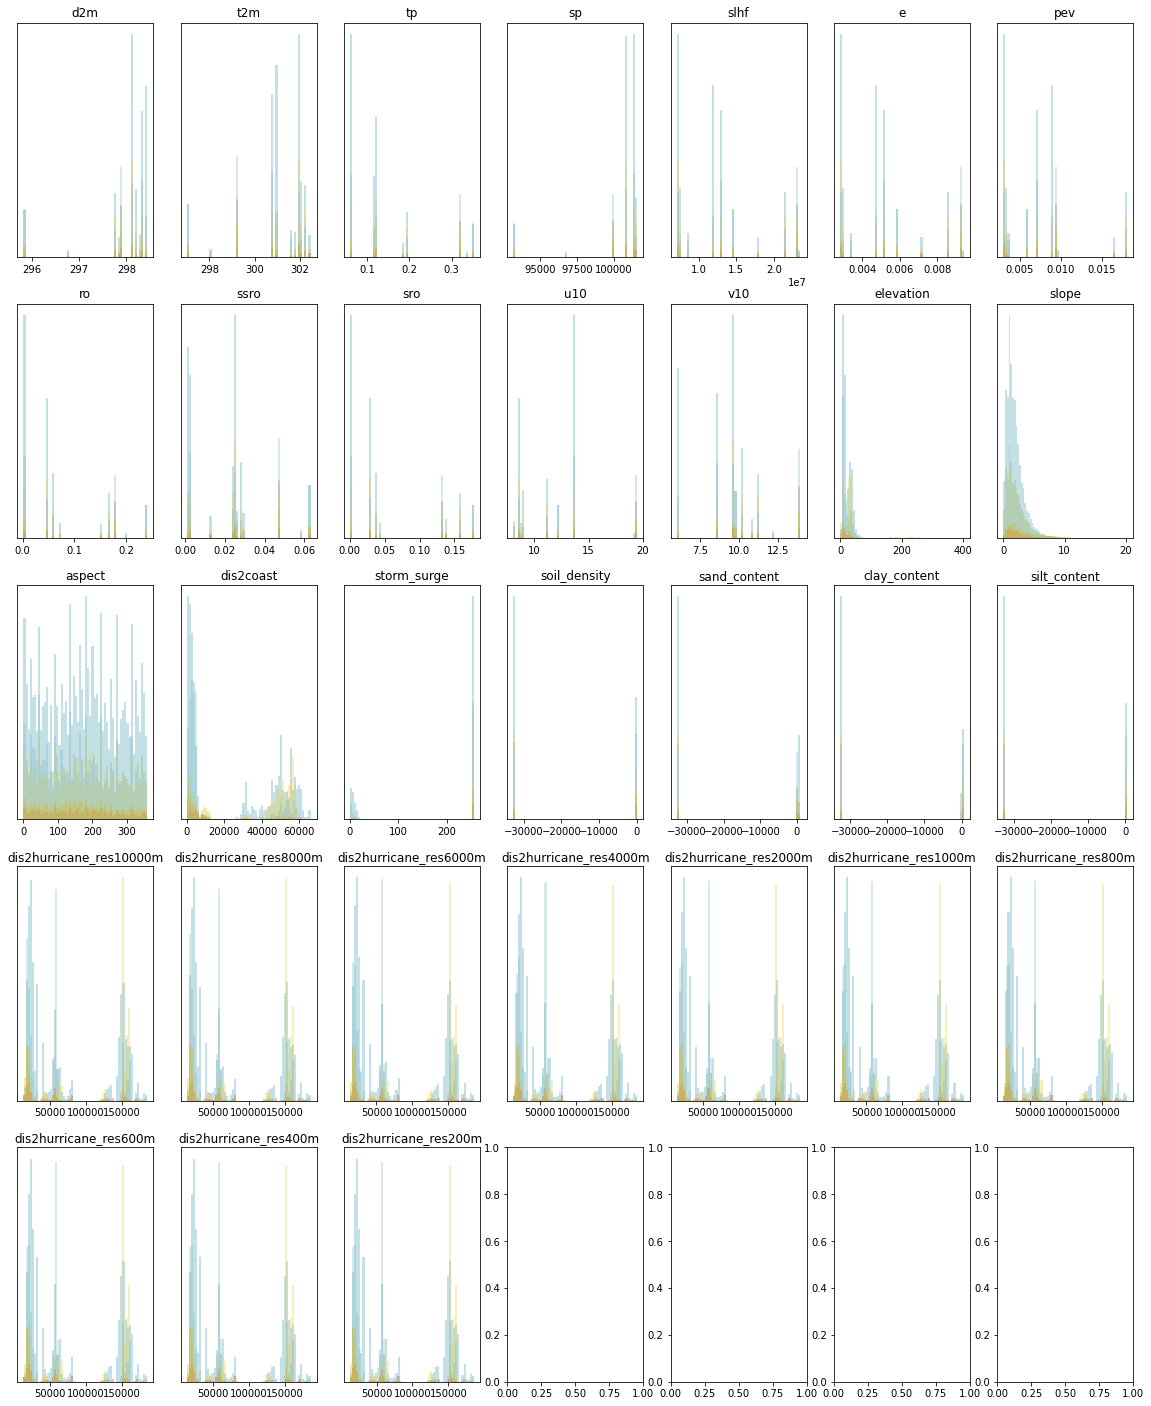

In [42]:
ECMWF_EF_df = ECMWF_EF_df.dropna(subset=ECMWF_all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 7, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(ECMWF_all_EF_features):
	# and each damage class
	for t in ECMWF_EF_df['damage_class'].unique():
		damage_data = ECMWF_EF_df[ECMWF_EF_df['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

Variances (Percentage):
[3.87802732e+01 2.32330905e+01 1.09935788e+01 8.62540723e+00
 4.65020292e+00 3.19013387e+00 2.88919874e+00 2.73474524e+00
 2.26117304e+00 1.64068453e+00 4.31111443e-01 3.15043443e-01
 1.90580690e-01 2.87397355e-02 2.23981375e-02 1.20187885e-02
 7.16269781e-04 4.81688664e-04 3.90240417e-04 1.36224340e-05
 1.10107523e-05 5.25731086e-06 1.32276744e-06 2.90495861e-07
 1.82415798e-08 1.03050654e-09 4.48749086e-10 1.20316443e-10
 1.71536845e-11 5.60862461e-29 1.13309801e-29]
Cumulative Variances (Percentage):
[ 38.78027318  62.01336369  73.00694247  81.6323497   86.28255262
  89.47268649  92.36188523  95.09663047  97.35780351  98.99848804
  99.42959948  99.74464293  99.93522362  99.96396335  99.98636149
  99.99838028  99.99909655  99.99957824  99.99996848  99.9999821
  99.99999311  99.99999837  99.99999969  99.99999998 100.
 100.         100.         100.         100.         100.
 100.        ]


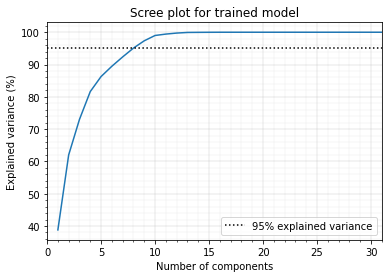

In [44]:
pca_analysis(ECMWF_EF_df, ECMWF_all_EF_features, 'damage_class')

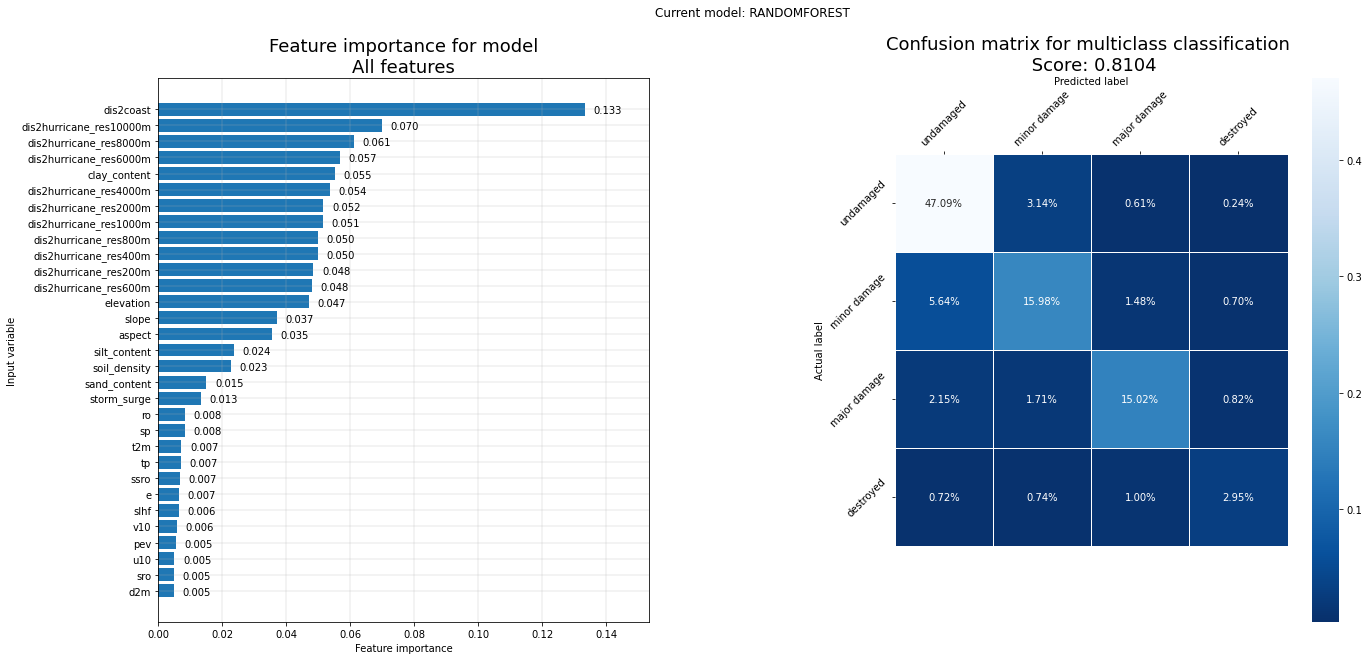

f1 score per class: [0.88279673 0.70431451 0.79456435 0.58292956]
f1 score macro: 0.7411512854084684
weighted f1 score: 0.8141631784335583
precision score: [0.92181374 0.67143084 0.76241611 0.54532775]
recall score: [0.84694848 0.74058504 0.82954308 0.62610088]
balanced accuracy: 0.7607943724919767
accuracy_score: 0.8104288683166446


In [45]:
# assign target variable
ECMWF_df_model_ready = assign_predictor(ECMWF_EF_df, 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
ECMWF_df_model_ready.head()

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    ECMWF_df_model_ready, ECMWF_all_EF_features, model_name='RandomForest')

Macro-averaged One-vs-Rest ROC AUC score:
0.93
None
Macro-averaged One-vs-Rest PR AUC score:
1.00
None


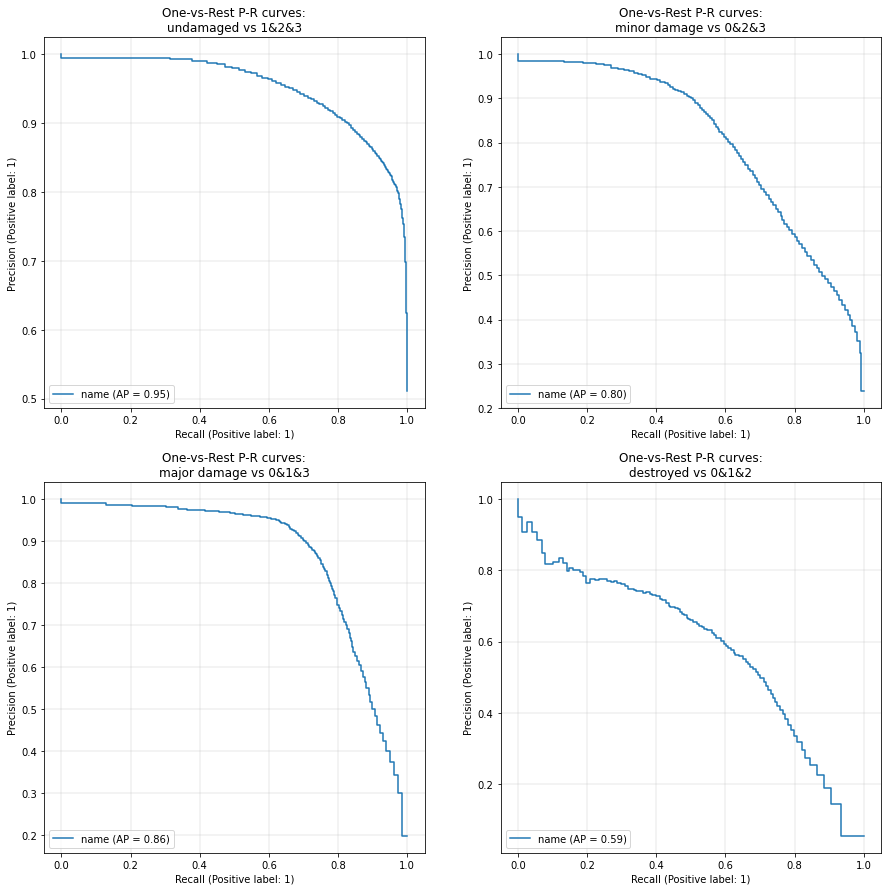

In [46]:
print(calc_curves_macro_av(ECMWF_y_test, ECMWF_y_score, curve_type='roc'))
print(calc_curves_macro_av(ECMWF_y_test, ECMWF_y_score, curve_type='pr'))
plot_pr_curves(y_test, y_score)

## Run all features with NOAA

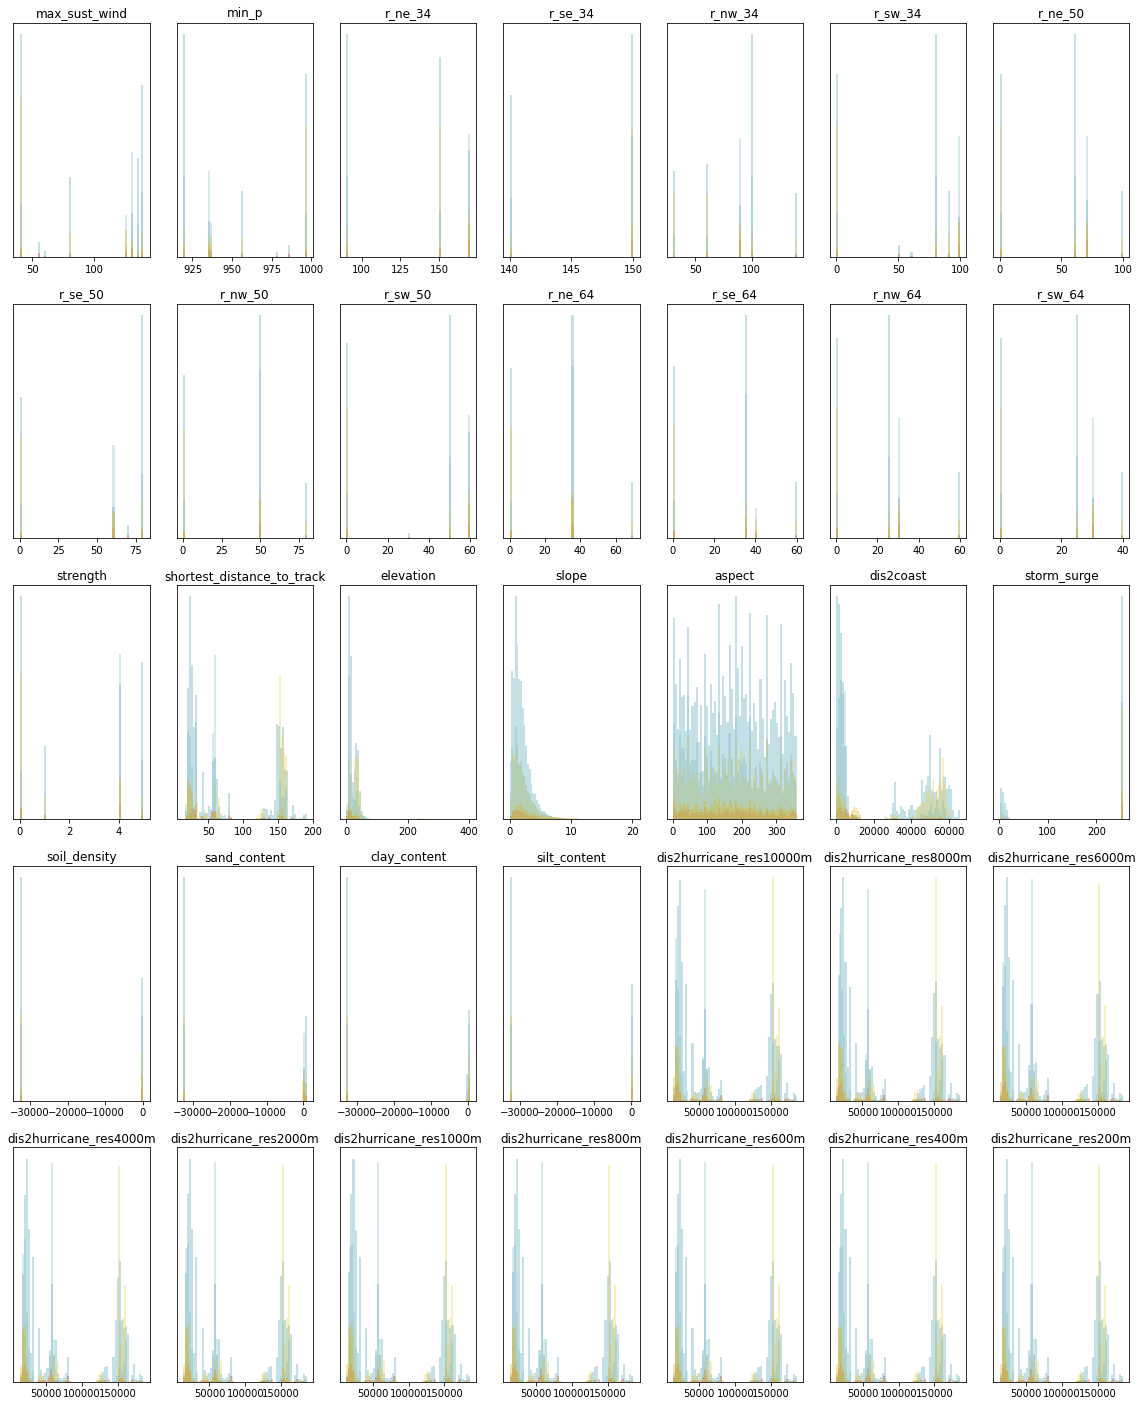

In [48]:
NOAA_EF_df = NOAA_df_no_dups.dropna(subset=NOAA_all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 7, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(NOAA_all_EF_features):
	# and each damage class
	for t in NOAA_df_no_dups['damage_class'].unique():
		damage_data = NOAA_df_no_dups[NOAA_df_no_dups['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

Variances (Percentage):
[6.70748582e+01 1.35700347e+01 5.14555371e+00 4.26588950e+00
 2.82705339e+00 1.98275623e+00 1.60022572e+00 1.54276970e+00
 1.27285908e+00 2.81216124e-01 2.42555220e-01 9.09066766e-02
 4.43584323e-02 3.63866444e-02 1.71634301e-02 4.79059476e-03
 3.86889923e-04 2.13019673e-04 9.61567282e-06 8.61860377e-06
 3.40299020e-06 8.38028962e-07 2.01063824e-07 1.50875374e-08
 8.80363579e-10 3.87102626e-10 1.05052504e-10 1.48477451e-11
 2.66068293e-28 2.12911643e-29 3.87292214e-30 2.43390215e-30
 5.51545171e-31 3.80459477e-31 1.46563408e-31]
Cumulative Variances (Percentage):
[ 67.07485823  80.64489295  85.79044666  90.05633616  92.88338955
  94.86614577  96.4663715   98.0091412   99.28200028  99.5632164
  99.80577162  99.8966783   99.94103673  99.97742337  99.9945868
  99.9993774   99.99976429  99.99997731  99.99998692  99.99999554
  99.99999894  99.99999978  99.99999998 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         1

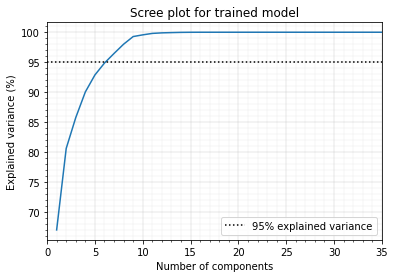

In [49]:
pca_analysis(NOAA_df_no_dups, NOAA_all_EF_features, 'damage_class')

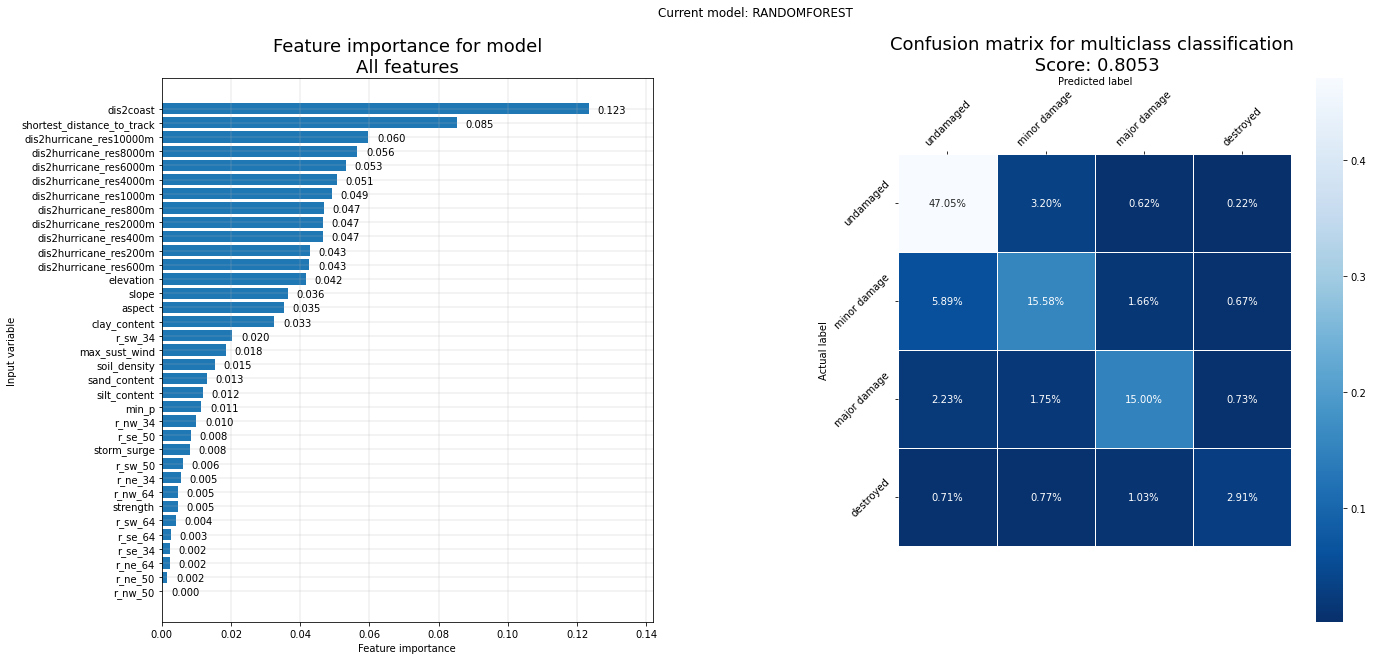

f1 score per class: [0.87971173 0.6909731  0.78922251 0.58466211]
f1 score macro: 0.736142361920399
weighted f1 score: 0.8095945081876647
precision score: [0.92100007 0.65459743 0.76107383 0.53695955]
recall score: [0.84196646 0.73162939 0.81953335 0.64166667]
balanced accuracy: 0.7586989665070338
accuracy_score: 0.8052900056678632


In [50]:
# assign target variable
NOAA_df_model_ready = assign_predictor(NOAA_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
ECMWF_df_model_ready.head()

model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features, model_name='RandomForest')

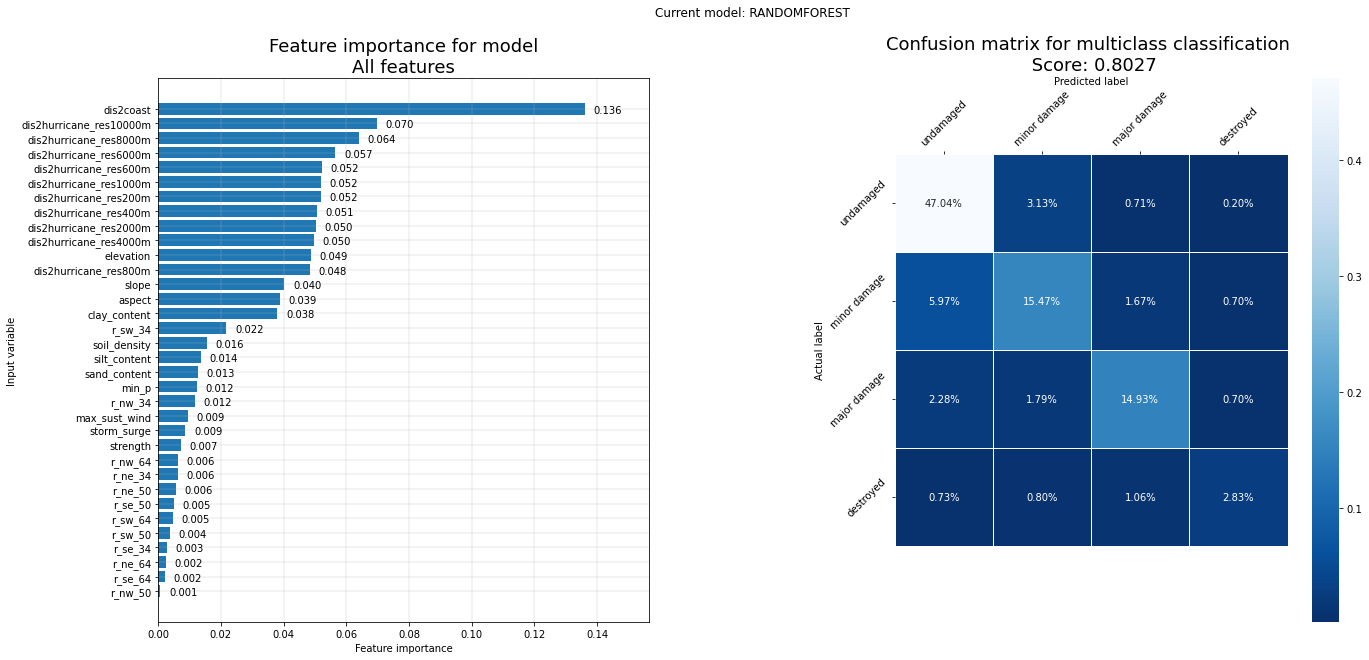

f1 score per class: [0.87838267 0.68766801 0.78436042 0.57559478]
f1 score macro: 0.7315014715496109
weighted f1 score: 0.8072947930016886
precision score: [0.92077816 0.64999206 0.757814   0.52301255]
recall score: [0.83971937 0.72998038 0.81283422 0.63993174]
balanced accuracy: 0.7556164302167918
accuracy_score: 0.802682788588702


In [65]:
model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features_notrack, model_name='RandomForest')

## Compare weather features only

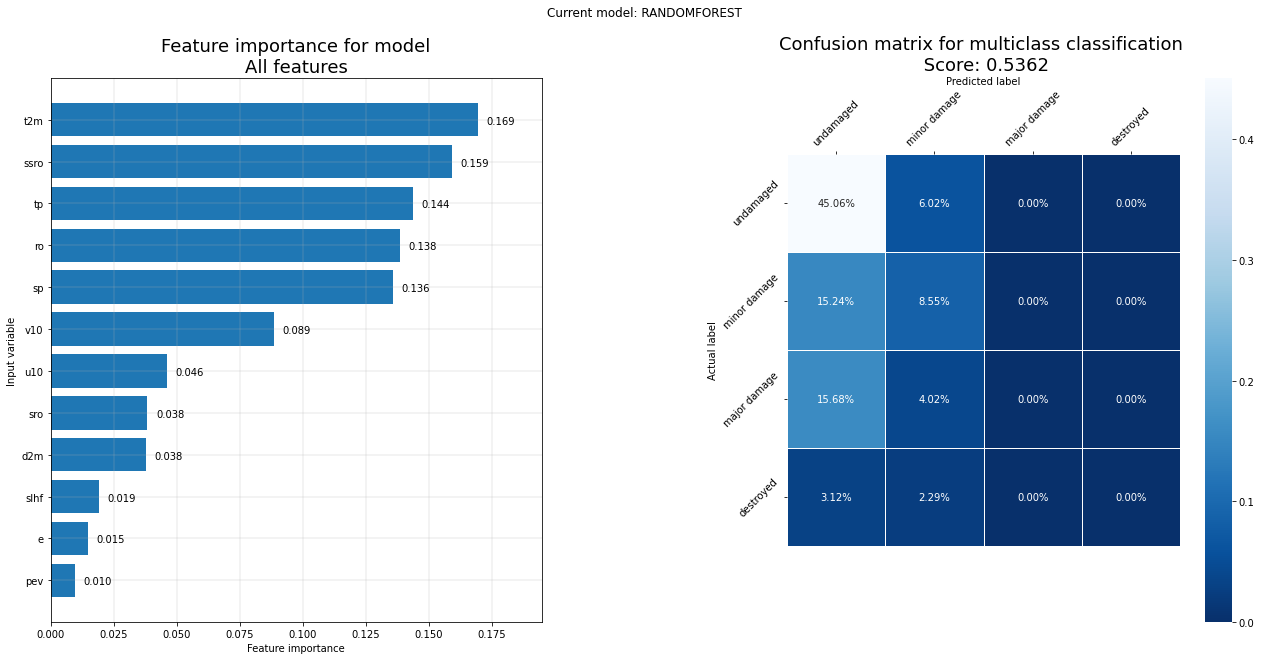

f1 score per class: [0.69224518 0.38291755 0.         0.        ]
f1 score macro: 0.26879068245753635
weighted f1 score: 0.6276329334580575
precision score: [0.88216584 0.35953629 0.         0.        ]
recall score: [0.5696136  0.40955137 0.         0.        ]
balanced accuracy: 0.24479124438300084
accuracy_score: 0.5361798601927074


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# for ECMWF
ECMWF_w_model, ECMWF_w_predictions, ECMWF_w_x_train, ECMWF_w_x_test, ECMWF_w_y_train, ECMWF_w_y_test, ECMWF_w_score, ECMWF_w_y_score, ECMWF_w_importances = train_test_display_model(
    ECMWF_df_model_ready, ECMWF_weather_features, model_name='RandomForest')

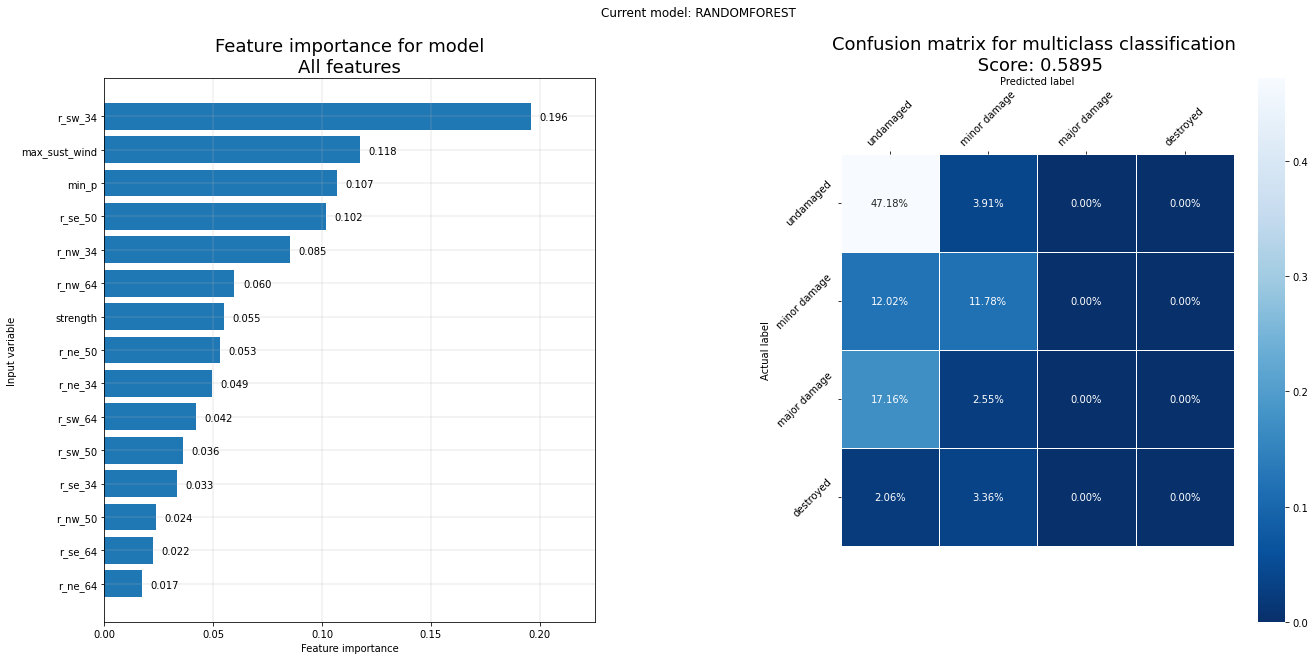

f1 score per class: [0.72860436 0.51906744 0.         0.        ]
f1 score macro: 0.3119179507919332
weighted f1 score: 0.6833716218430445
precision score: [0.92351505 0.49499762 0.         0.        ]
recall score: [0.60162876 0.54559776 0.         0.        ]
balanced accuracy: 0.28680662954243735
accuracy_score: 0.589533345928585


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# for NOAA
NOAA_w_model, NOAA_w_predictions, NOAA_w_x_train, NOAA_w_x_test, NOAA_w_y_train, NOAA_w_y_test, NOAA_w_score, NOAA_w_y_score, NOAA_w_importances = train_test_display_model(
    NOAA_df_model_ready, NOAA_weather_features, model_name='RandomForest')

Based on f1 score, precision, recall and accuracy, the NOAA dataset provides the most 

### Run model now three times
for the top three performing distance to hurricane track, res 1000, res8000 and res600.

In [59]:
NOAA_EF_features_loop_track = [['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m'], ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res8000m'], ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res6000m'],
       ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'shortest_distance_to_track']]

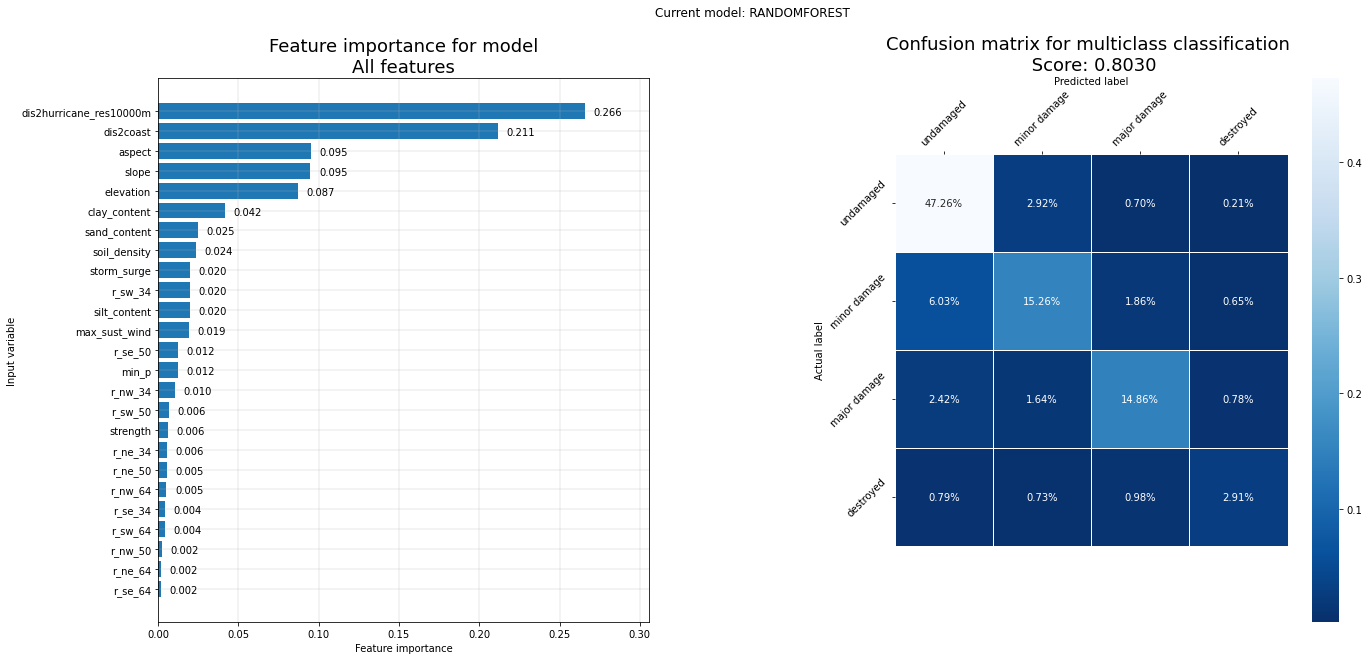

f1 score per class: [0.87861759 0.68830948 0.7800476  0.58453374]
f1 score macro: 0.7328771005421177
weighted f1 score: 0.8079922324570965
precision score: [0.92521636 0.64141655 0.75417066 0.5376569 ]
recall score: [0.83648766 0.74259974 0.8077634  0.64036545]
balanced accuracy: 0.7568040633881612
accuracy_score: 0.8029850746268656


In [60]:
model_10000m, predictions_10000m, x_train_10000m, x_test_10000m, y_train_10000m, y_test_10000m, score_10000m, y_score_10000m, importances_10000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[0], model_name='RandomForest')

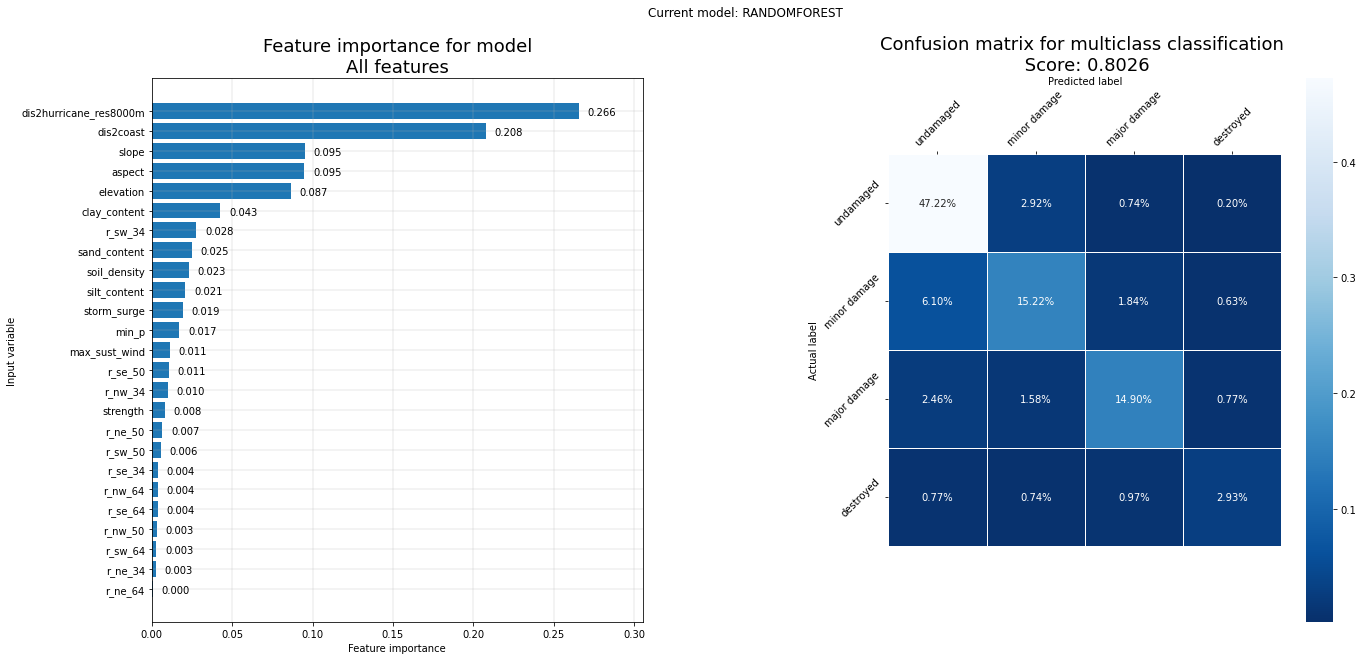

f1 score per class: [0.87734326 0.68790026 0.78074866 0.58899431]
f1 score macro: 0.7337466228867058
weighted f1 score: 0.8076805756974049
precision score: [0.92432872 0.63966968 0.75589645 0.54114365]
recall score: [0.83490345 0.74399704 0.8072906  0.64612823]
balanced accuracy: 0.7580798313709686
accuracy_score: 0.8026450028339316


In [61]:
model_8000m, predictions_8000m, x_train_8000m, x_test_8000m, y_train_8000m, y_test_8000m, score_8000m, y_score_8000m, importances_8000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[1], model_name='RandomForest')

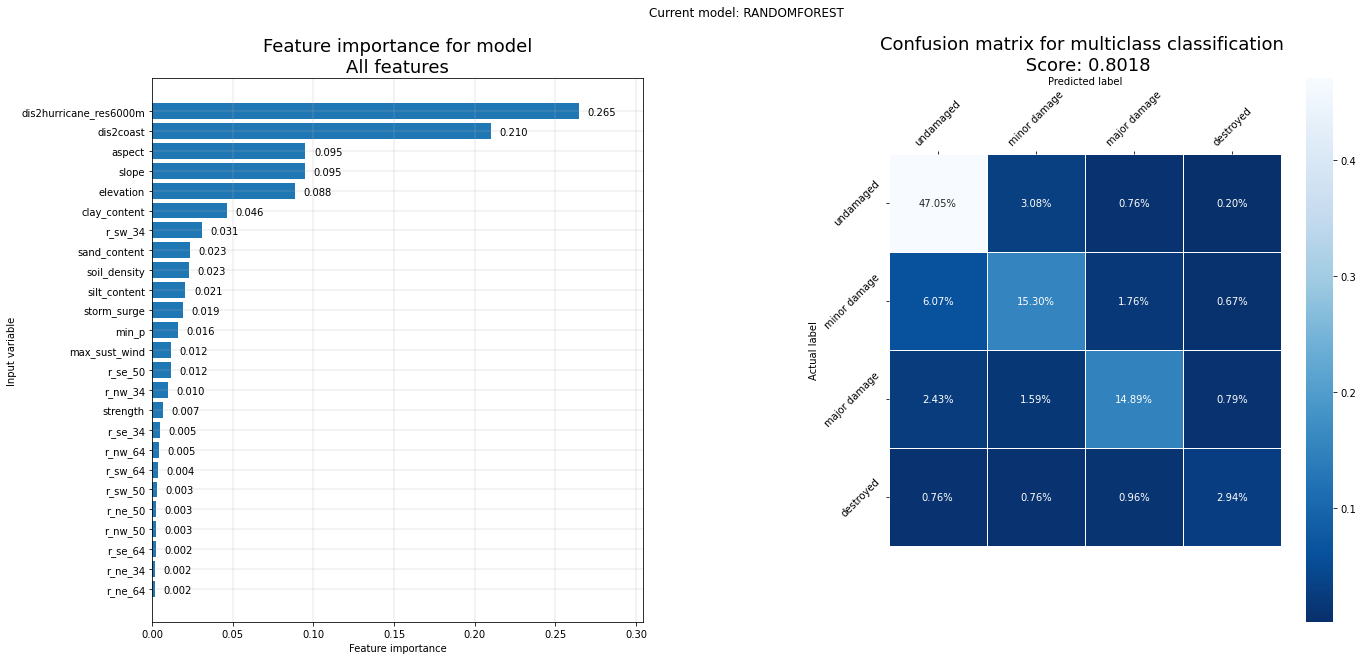

f1 score per class: [0.87624477 0.68731964 0.78217724 0.58748115]
f1 score macro: 0.7333056968869116
weighted f1 score: 0.8065177778606072
precision score: [0.92100007 0.64300461 0.7557047  0.5432357 ]
recall score: [0.83563758 0.73819508 0.81057178 0.63957307]
balanced accuracy: 0.7559943782860588
accuracy_score: 0.8018137162289817


In [62]:
model_6000m, predictions_6000m, x_train_6000m, x_test_600m, y_train_600m, y_test_6000m, score_6000m, y_score_6000m, importances_6000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[2], model_name='RandomForest')

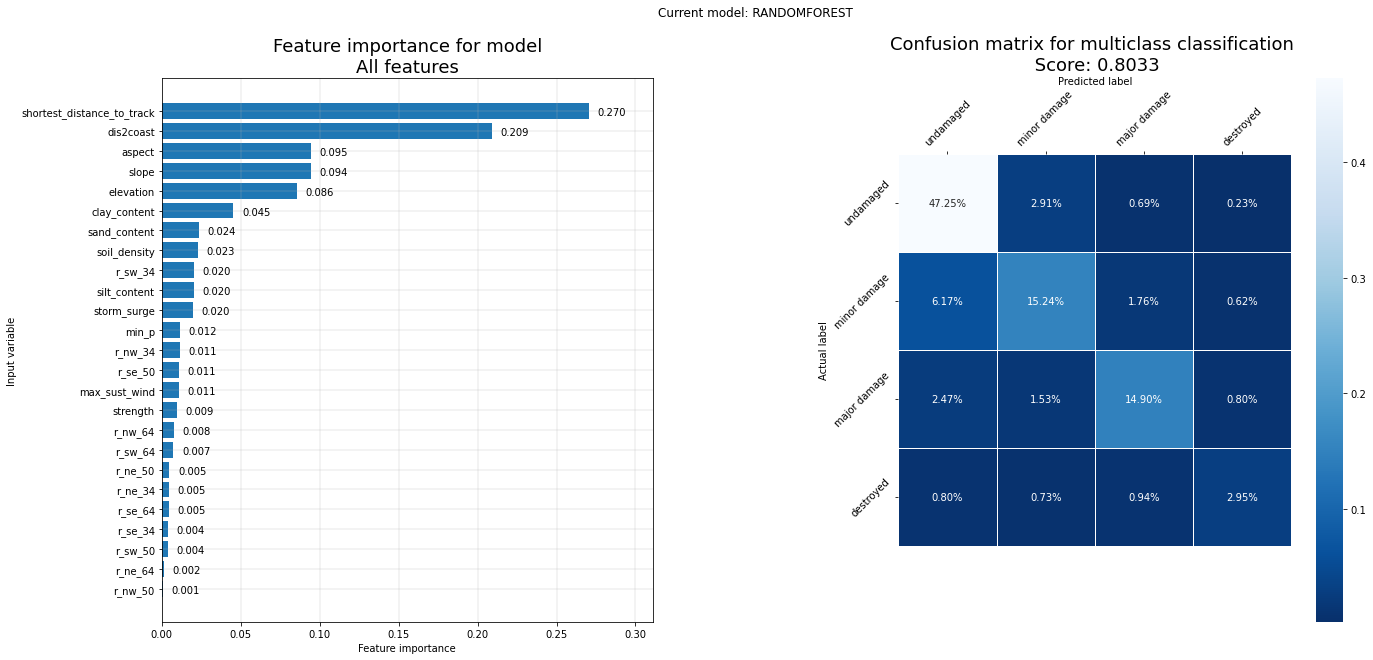

f1 score per class: [0.87679686 0.68940171 0.78400955 0.58823529]
f1 score macro: 0.7346108521560135
weighted f1 score: 0.8082857172864284
precision score: [0.92492048 0.64046371 0.75589645 0.54393305]
recall score: [0.83343331 0.74643716 0.81429457 0.64039409]
balanced accuracy: 0.7586397834459192
accuracy_score: 0.8032873606650293


In [63]:
model_shortest, predictions_shortest, x_train_shortest, x_test_shortest, y_train_shortest, y_test_shortest, score_shortest, y_score_shortest, importances_shortest = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[3], model_name='RandomForest')

Quickly check if 10000m resolution for hurricane track is also best performing for ECMWF

In [ ]:
# quickly check

# Logistic Regression Model

In [ ]:
model = LogisticRegression(max_iter = 1e6)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.coef_[0]
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random forest hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(rf_random.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

In [ ]:
# this section is Work In Progress. 

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = model.score(x_train, y_train)

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

In [ ]:
best["criterion"] = "entropy"

In [ ]:
model = RandomForestClassifier(**best)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)
model.score(x_test, y_test)

In [ ]:
importance = best.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest Model

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# XGBoost Model

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# This space is JUST for rlazando
